In [ ]:
import re

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from collections import defaultdict
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from wordcloud import WordCloud


from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import f1_score

from scipy.sparse import csr_matrix, hstack
from sklearn.feature_extraction.text import TfidfVectorizer
from sentence_transformers import SentenceTransformer

from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import RidgeCV

import warnings
warnings.simplefilter('ignore')
from sklearn.decomposition import TruncatedSVD

In [3]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
sample = pd.read_csv("sample_submission.csv")

In [5]:
def clean_text(text):
    text = text.lower()                             # 小文字化
    text = re.sub(r'http\S+', '', text)             # URL削除
    text = re.sub(r'@\w+', '', text)                # メンション削除
    text = re.sub(r'#', '', text)                   # ハッシュタグ記号だけ削除
    text = re.sub(r'[^\w\s]', '', text)             # 記号削除
    text = re.sub(r'\d+', '', text)                 # 数字削除
    return text

In [7]:
train['clean_text'] = train['text'].apply(clean_text)

test['clean_text'] = test['text'].apply(clean_text)

In [9]:
train.head()

,id,keyword,location,text,target,clean_text
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,our deeds are the reason of this earthquake ma...
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,forest fire near la ronge sask canada
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,all residents asked to shelter in place are be...
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,people receive wildfires evacuation orders in...
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,just got sent this photo from ruby alaska as s...


In [11]:
#各テキストの文字数と単語数
train['text_length'] = train['text'].apply(lambda x: len(x))
train['num_words'] = train['text'].apply(lambda x: len(x.split()))

test['text_length'] = test['text'].apply(lambda x: len(x))
test['num_words'] = test['text'].apply(lambda x: len(x.split()))

In [13]:
# stopwordの中身を一部確認
stop_words = stopwords.words('english')
print('stopwordsの一部を確認:', stop_words[:10])

stopwordsの一部を確認: ['a', 'about', 'above', 'after', 'again', 'against', 'ain', 'all', 'am', 'an']


In [15]:
# 1つのデータのtextに対して「単語ごとの分割」→「stop_wordsでないものを取り出す」→「記号以外を取り出す」という処理を行う関数を作成
def remove_stopwords(text):
    words = ' '.join([re.sub('[^a-zA-Z]+', '', word) for word in text.split() if word not in stop_words])
    return words

In [17]:
# 上記関数を適用
train['text_remove'] = train['clean_text'].apply(lambda x: remove_stopwords(x))
test['text_remove'] = test['clean_text'].apply(lambda x: remove_stopwords(x))
train.head()

,id,keyword,location,text,target,clean_text,text_length,num_words,text_remove
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,our deeds are the reason of this earthquake ma...,69,13,deeds reason earthquake may allah forgive us
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,forest fire near la ronge sask canada,38,7,forest fire near la ronge sask canada
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,all residents asked to shelter in place are be...,133,22,residents asked shelter place notified officer...
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,people receive wildfires evacuation orders in...,65,8,people receive wildfires evacuation orders cal...
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,just got sent this photo from ruby alaska as s...,88,16,got sent photo ruby alaska smoke wildfires pou...


In [19]:
#記号の数
def count_punctuation(text):
    punct_pattern = r'[!-/:-@[-`{-~]'  # 半角記号
    return len(re.findall(punct_pattern, text))

In [21]:
train["punct_count"] = train["text"].apply(count_punctuation)
test["punct_count"] = test["text"].apply(count_punctuation)

In [23]:
def extract_text_features(text):
    features = {}

    # 総文字数（ゼロ除算防止のため max を使用）
    total_chars = max(len(text), 1)
    
    # 大文字の割合（A-Z の出現数 / 総文字数）
    features['uppercase_ratio'] = len(re.findall(r'[A-Z]', text)) / total_chars

    # 数字の出現数（0-9）
    features['digit_count'] = len(re.findall(r'\d', text))

    # URLの有無（True/False → int型で1/0に）
    features['has_url'] = int(bool(re.search(r'https?://\S+|www\.\S+', text)))

    # @（メンション）の出現数
    features['mention_count'] = text.count('@')

    # #（ハッシュタグ）の出現数
    features['hashtag_count'] = text.count('#')

    return features

In [25]:
# 特徴量を展開して列に追加
train_df = train['text'].apply(extract_text_features).apply(pd.Series)

# 元のdfと結合
train = pd.concat([train, train_df], axis=1)

train.head()

,id,keyword,location,text,target,clean_text,text_length,num_words,text_remove,punct_count,uppercase_ratio,digit_count,has_url,mention_count,hashtag_count
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,our deeds are the reason of this earthquake ma...,69,13,deeds reason earthquake may allah forgive us,1,0.144928,0.0,0.0,0.0,1.0
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,forest fire near la ronge sask canada,38,7,forest fire near la ronge sask canada,1,0.131579,0.0,0.0,0.0,0.0
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,all residents asked to shelter in place are be...,133,22,residents asked shelter place notified officer...,3,0.015038,0.0,0.0,0.0,0.0
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,people receive wildfires evacuation orders in...,65,8,people receive wildfires evacuation orders cal...,2,0.015385,5.0,0.0,0.0,1.0
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,just got sent this photo from ruby alaska as s...,88,16,got sent photo ruby alaska smoke wildfires pou...,2,0.034091,0.0,0.0,0.0,2.0


In [27]:
# 特徴量を展開して列に追加
test_df = test['text'].apply(extract_text_features).apply(pd.Series)

# 元のdfと結合
test = pd.concat([test, test_df], axis=1)

test.head()

,id,keyword,location,text,clean_text,text_length,num_words,text_remove,punct_count,uppercase_ratio,digit_count,has_url,mention_count,hashtag_count
0,0,NaN,NaN,Just happened a terrible car crash,just happened a terrible car crash,34,6,happened terrible car crash,0,0.029412,0.0,0.0,0.0,0.0
1,2,NaN,NaN,"Heard about #earthquake is different cities, s...",heard about earthquake is different cities sta...,64,9,heard earthquake different cities stay safe ev...,3,0.015625,0.0,0.0,0.0,1.0
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are...",there is a forest fire at spot pond geese are ...,96,19,forest fire spot pond geese fleeing across str...,2,0.010417,0.0,0.0,0.0,0.0
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires,apocalypse lighting spokane wildfires,40,4,apocalypse lighting spokane wildfires,3,0.050000,0.0,0.0,0.0,2.0
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan,typhoon soudelor kills in china and taiwan,45,8,typhoon soudelor kills china taiwan,0,0.088889,2.0,0.0,0.0,0.0


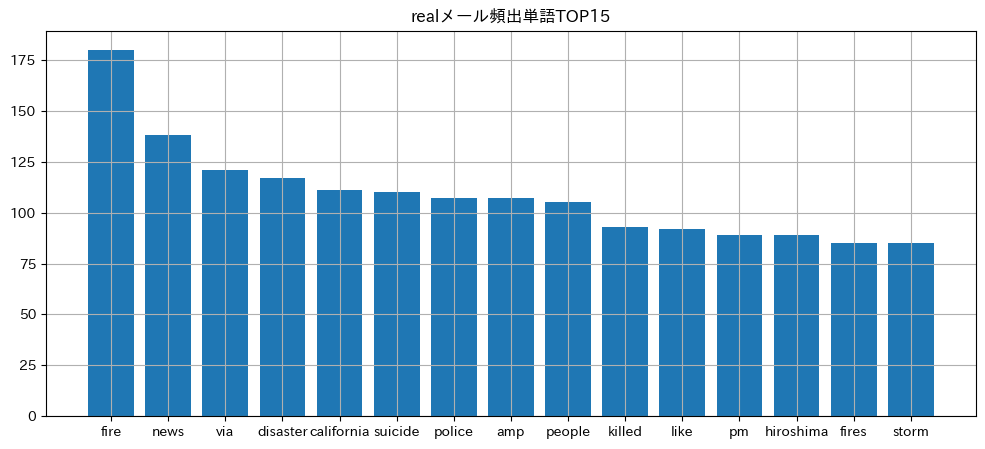

In [29]:
#realに出現する単語の頻度の可視化

# corpusに全ての出現単語を要素として取得
corpus=[]
for x in train[train['target']==1]['text_remove'].str.split():
    for i in x:
        corpus.append(i)

# corpusを辞書型で集計
plt.figure(figsize=(12, 5))
dic = defaultdict(int)
for word in corpus:
    dic[word]+=1

top=sorted(dic.items(), key=lambda x: x[1], reverse=True)[:15] 
x,y=zip(*top)
plt.bar(x,y)
plt.title('realメール頻出単語TOP15')
plt.grid()
plt.show()

In [31]:
disaster_keywords = ["fire","news","via","disaster","california","suicide","police","apm","people"]

def contains_disaster_word(text):
    words = text.split()
    return int(any(word in words for word in disaster_keywords))

train['has_disaster_word'] = train['clean_text'].apply(contains_disaster_word)
test['has_disaster_word'] = test['clean_text'].apply(contains_disaster_word)

In [33]:
# keyword列の欠損処理
train['keyword'] = train['keyword'].fillna('no_keyword')
test['keyword'] = test['keyword'].fillna('no_keyword')
# Label Encoding
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
train['keyword_enc'] = le.fit_transform(train['keyword'])
test['keyword_enc'] = le.transform(test['keyword'])

In [35]:
other_feat_train = train.drop(["id","keyword","location","text","target","clean_text","text_remove"],axis=1)
other_feat_test = test.drop(["id","keyword","location","text","clean_text","text_remove"],axis=1)

In [37]:
y = train["target"]

In [39]:
other_feat_train = other_feat_train.reset_index(drop=True)
train = train.reset_index(drop=True)
y = y.reset_index(drop=True)

In [44]:
# 文章をベクトル化 'all-mpnet-base-v2'
model_base = SentenceTransformer('all-mpnet-base-v2')
X_bert_base = model_base.encode(train['text'].tolist(), show_progress_bar=True)
X_test_bert_base = model_base.encode(test['text'].tolist(), show_progress_bar=True)

# ベクトル圧縮
svd = TruncatedSVD(n_components=100, random_state=42)
X_bert_reduced = svd.fit_transform(X_bert_base)
X_test_bert_reduced = svd.transform(X_test_bert_base)


Batches:   0%|          | 0/238 [00:00<?, ?it/s]

Batches:   0%|          | 0/102 [00:00<?, ?it/s]

In [46]:
# TF-IDF　Word n-gram 、stop_words指定なし
vectorizer = TfidfVectorizer(ngram_range=(1, 3),analyzer='word',max_features=10000)
X_tfidf_no = vectorizer.fit_transform(train['text'])
X_test_tfidf_no = vectorizer.transform(test['text'])

# Combine features bert圧縮と結合
X_combined_nobase = hstack([X_tfidf_no, csr_matrix(X_bert_reduced)])
X_test_combined_nobase = hstack([X_test_tfidf_no, csr_matrix(X_test_bert_reduced)])

In [48]:
#MultinomialNB,XGB metamodel RidgeCV（正則化を調整） BERT'all-mpnet-base-v2' TF-IDF　Word n-gram stop_words指定なし
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

oof_nb = np.zeros(len(train))
oof_xgb = np.zeros(len(train))
test_pred_nb = np.zeros(len(test))
test_pred_xgb = np.zeros(len(test))

for train_idx, val_idx in cv.split(train, y):
    # split
    X_train_nb, X_val_nb = X_tfidf_no[train_idx], X_tfidf_no[val_idx]
    X_train_xgb = hstack([X_combined_nobase[train_idx], other_feat_train.iloc[train_idx]])
    X_val_xgb = hstack([X_combined_nobase[val_idx], other_feat_train.iloc[val_idx]])
    
    # train
    model_nb = MultinomialNB()
    model_xgb = XGBClassifier(eval_metric='logloss', use_label_encoder=False)

    model_nb.fit(X_train_nb, y[train_idx])
    model_xgb.fit(X_train_xgb, y[train_idx])

    # OOF予測
    oof_nb[val_idx] = model_nb.predict_proba(X_val_nb)[:,1]
    oof_xgb[val_idx] = model_xgb.predict_proba(X_val_xgb)[:,1]

    # test用平均予測
    test_pred_nb += model_nb.predict_proba(X_test_tfidf_no)[:,1] / cv.n_splits
    test_pred_xgb += model_xgb.predict_proba(hstack([X_test_combined_nobase, other_feat_test]))[:,1] / cv.n_splits

# スタッキング用の2次元特徴量
X_stack_train = np.vstack([oof_nb, oof_xgb]).T
X_stack_test = np.vstack([test_pred_nb, test_pred_xgb]).T

# メタモデル
meta_model_rid_no = RidgeCV(alphas=np.logspace(-3, 3, 10))
meta_model_rid_no.fit(X_stack_train, y)


RidgeCV(alphas=array([1.00000000e-03, 4.64158883e-03, 2.15443469e-02, 1.00000000e-01,
       4.64158883e-01, 2.15443469e+00, 1.00000000e+01, 4.64158883e+01,
       2.15443469e+02, 1.00000000e+03]))

In [50]:
#しきい値探索
best_f1 = 0
best_thresh = 0.5

for thresh in np.arange(0.3, 0.7, 0.01):
    train_pred_rid_no = meta_model_rid_no.predict(X_stack_train)
    oof_pred_bin = (train_pred_rid_no > thresh).astype(int)
    f1 = f1_score(y, oof_pred_bin)
    if f1 > best_f1:
        best_f1 = f1
        best_thresh = thresh

print(f"Best threshold: {best_thresh}, F1: {best_f1:.4f}")

Best threshold: 0.4500000000000001, F1: 0.7878


In [ ]:
final_pred_rid_no = (meta_model_rid_no.predict(X_stack_test) >=best_thresh).astype(int)
sample["target"] = final_pred_rid_no
sample.to_csv("sobmission_mnb_xgb_rid_no.csv",index=None)
#LB:0.83481（ベストモデル）